# Generative AI with Python (with some Machine Learning)

## Text to Image with StableDiffusion

In [1]:
import torch
from diffusers import (
    StableDiffusionPipeline,
    DiffusionPipeline,
    AutoPipelineForText2Image,
    DEISMultistepScheduler,
)

/home/work/miniforge3/envs/compile-test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


It's good to check if CUDA is working.

In [2]:
print(torch.cuda.is_available())

True


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]An error occurred while trying to fetch /home/work/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/work/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  20%|██        | 1/5 [00:00<00:01,  3.33it/s]An error occurred while trying to fetch /home/work/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/work/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an

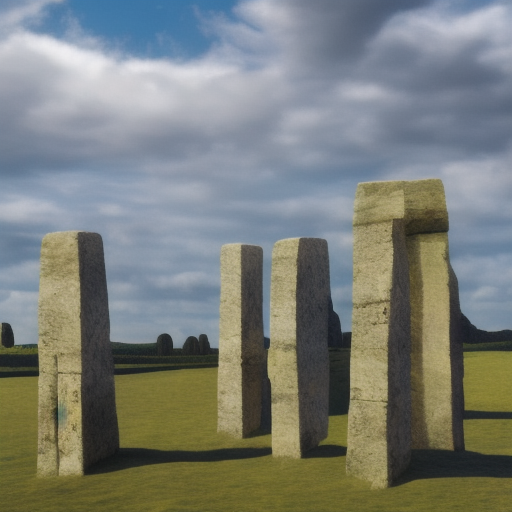

In [3]:
pipe = DiffusionPipeline.from_pretrained(
    "segmind/tiny-sd", torch_dtype=torch.float16
)
prompt = "stonehenge, sharp details, realistic, 4K"
pipe = pipe.to("cuda")
image = pipe(prompt).images[0]
display(image)

100%|██████████| 50/50 [00:02<00:00, 18.81it/s]


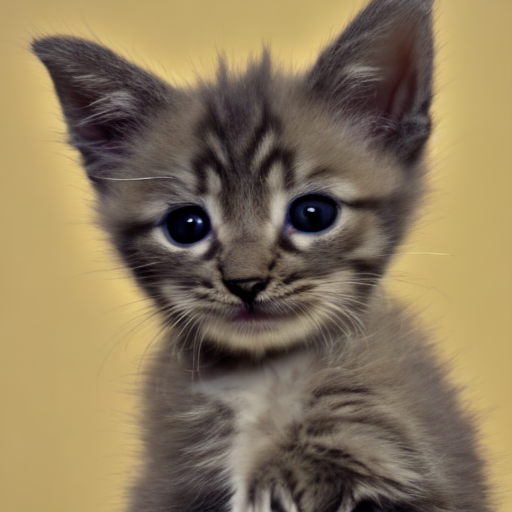

In [5]:
model_id = "nitrosocke/Ghibli-Diffusion"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "kitten"
image = pipe(prompt).images[0]
display(image)

100%|██████████| 50/50 [00:02<00:00, 18.60it/s]


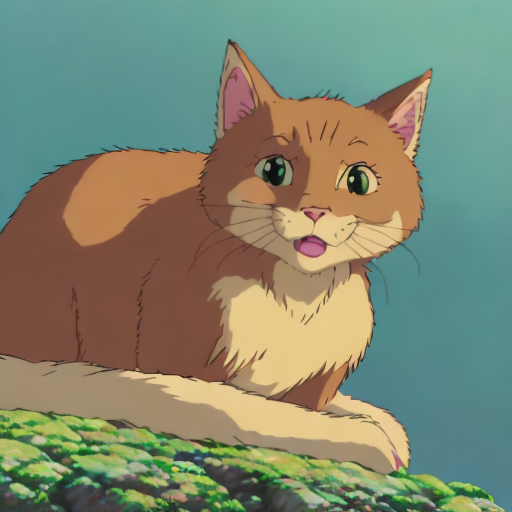

In [6]:
prompt = "ghibli style, kitten"
image = pipe(prompt).images[0]
display(image)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 16.01it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['art , sharp focus , vivid colors']
100%|██████████| 50/50 [00:04<00:00, 11.61it/s]


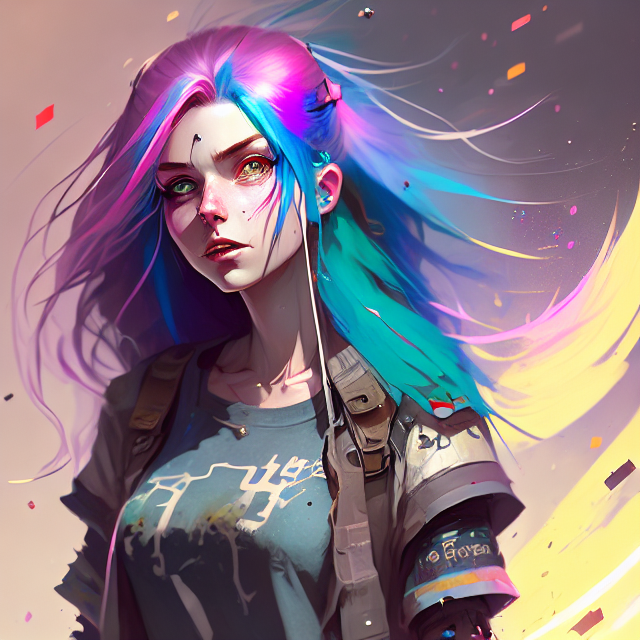

In [7]:
model_id = "dreamlike-art/dreamlike-diffusion-1.0"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "dreamlikeart, a grungy woman with rainbow hair, travelling between dimensions, dynamic pose, happy, soft eyes and narrow chin, extreme bokeh, dainty figure, long hair straight down, torn kawaii shirt and baggy jeans, In style of by Jordan Grimmer and greg rutkowski, crisp lines and color, complex background, particles, lines, wind, concept art, sharp focus, vivid colors"
image = pipe(prompt).images[0]
display(image)

Loading pipeline components...:  86%|████████▌ | 6/7 [00:00<00:00, 15.18it/s]/home/work/miniforge3/envs/compile-test/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:30: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
100%|██████████| 50/50 [00:02<00:00, 20.21it/s]


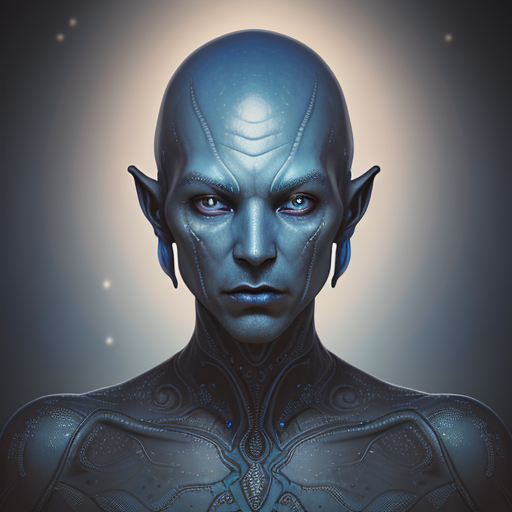

In [8]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "lykon/dreamshaper-8", torch_dtype=torch.float16, variant="fp16"
)
pipe.scheduler = DEISMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

prompt = "portrait photo of blue alien man, light bokeh, intricate, elegant, sharp focus, soft lighting, vibrant colors"

# generator = torch.manual_seed(33)
image = pipe(prompt).images[0]
display(image)

In [ ]:
model_id = "dreamlike-art/dreamlike-photoreal-2.0"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

image = pipe(prompt).images[0]
display(image)

Fetching 12 files:  75%|███████▌  | 9/12 [07:19<02:26, 48.79s/it]


### Prompt Enhancement

https://www.neuralframes.com/tools/stable-diffusion-prompt-generator  
https://www.feedough.com/stable-diffusion-prompt-generator/

### Negative Prompts

## Upscaling

Explanation of upscaling.

In [ ]:
from diffusers import StableDiffusionUpscalePipeline

In [ ]:
model_id = "stabilityai/stable-diffusion-x4-upscaler"
pipeline = StableDiffusionUpscalePipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")

## Dreambooth

Explanation of dreambooth.

In [ ]:
from py_dreambooth.dataset import LocalDataset
from py_dreambooth.model import SdDreamboothModel
from py_dreambooth.trainer import LocalTrainer
from py_dreambooth.utils.image_helpers import display_images
from py_dreambooth.utils.prompt_helpers import make_prompt

## Large Language Models (LLMs)

### What are Large Language Models?

Large Language Models 

"auto-correct on steroids"

[A short introduction to LLMs](https://www.youtube.com/watch?v=LPZh9BOjkQs)

### Ollama & Generating Text

**Ollama** is a tool that allows us to run LLMs locally. It can be downloaded and used entirely for _free_.

But what does it mean to run something _locally_? That means you're running it _solely_ on your own machine, rather than sending information back and forth with an online service.

This has some key advantages:
- cost
- privacy
- doesn't depend on stable/fast internet access
- peformance isn't affected by how many other people are using the same online services at a given time

To test our Ollama installation, we can see the output from inputting `ollama` in the command line.

It's also possible to do this within Python by using the `subprocess` library. So that's one option...

In [ ]:
import subprocess

# Run the `echo` command and capture output
result = subprocess.run(["ollama"], text=True)

print("Output from command line:")
print(result.stdout)

This gives us a list of commands that we can use with Ollama. For our purposes, we're mainly concerned with being able to pull models, list what models are on our system, and remove the ones we no longer want to use. In a fresh installtion, Ollama comes with zero models, but the script has _pulled_ a few already to make things easier. We can use the ollama-python library to list these models. Of course, the command line works too.

In [ ]:
import ollama

ollama.list().models

That is quite a bit of information, so we can go through this _return value_ to extract just the information that's more human-friendly.

In [ ]:
for model in ollama.list().models:
    print(model.model)

Now we have a plain list of the models on the system - this shows us what was downloaded (or _pulled_) by running the installation script.

To start with, I'm going to create a _variable_ for storing the name of the model I wish to use. This is going to be a _parameter_ that we give repeatedly to the ollama python library, so it makes sense to write it down once and avoid repeating ourselves.

In [ ]:
# dophin-phi is 2.7b
DOLPHIN_PHI = "dolphin-phi"
# this particular deepseek model is 7b
DEEPSEEK = "deepseek-r1:7b"
# glm4 9b version
GLM4 = "glm4:latest"
# moondream
MOONDREAM = "moondream"

A convention when programming in Python is to write constants -- variables that are set once and never changes -- in all-caps. This doesn't affect how your code runs, but it can be nice for making things more ordered. I feel it tells me this bit of information is "important" in some way, while using less mental effort.

In [ ]:
from ollama import chat

response = chat(
    model=DOLPHIN_PHI,
    messages=[
        {
            "role": "user",
            "content": "What is the capital of France?",
        },
    ],
)
print(response["message"]["content"])

### Streaming

In [ ]:
stream = chat(
    model=DOLPHIN_PHI,
    messages=[{"role": "user", "content": "Why is the sky blue?"}],
    stream=True,
)

for chunk in stream:
    print(chunk["message"]["content"], end="", flush=True)

### Vision Language Models (VLMs)

Vision Language Models can be used to describe images. Let's try this out with this clown image.

![](../pictures/clown.jpg)

First, we need to load the image. To do this, we need ot make use of the `base64` library as it allows us to convert the image into a format that a VLM can understand.

In [ ]:
import base64

# load an image as base64
with open("../pictures/clown.jpg", "rb") as image_file:
    data = base64.b64encode(image_file.read()).decode("utf-8")

Now that the image has been loaded, we can send it to the VLM `moondream`, and ask it to tell us what the image contains.

In [ ]:
response = ollama.chat(
    model=MOONDREAM,
    messages=[
        {
            "role": "user",
            "content": "What's in this image?",
            "images": [data],  # pass the image in the images field
        },
    ],
)
print(response["message"]["content"])

We can also ask moondream to explain certain details in the image to us.

In [ ]:
response = ollama.chat(
    model=MOONDREAM,
    messages=[
        {
            "role": "user",
            "content": "What colour is his nose?",
            "images": [data],  # pass the image in the images field
        },
    ],
)
print(response["message"]["content"])

We can see a list of vision models that work with Ollama here: https://ollama.com/search?c=vision

### Small Language Models

Language Models come in very small sizes too. Some examples include `smollm` and `tinyllama`. While these models are more prone to hallucination, and have more limited "intelligence," they can run quite fast even on less powerful hardware such as Raspberry Pis and computers with older GPUs.

### Hallucination

![](../pictures/how-to-cook-your-dragon.webp)

In [ ]:
response = chat(
    model=DOLPHIN_PHI,
    messages=[
        {
            "role": "user",
            "content": "What are some good cookbooks on how to use dragon meat?",
        },
    ],
)
print(response["message"]["content"])

### Thinking Models

Explanation of thinking/reasoning models goes here...

In [ ]:
response = chat(
    model=DEEPSEEK,
    messages=[
        {
            "role": "user",
            "content": "What is the capital of France?",
        },
    ],
)
print(response["message"]["content"])

#### The Strawberry Test

In [ ]:
stream = chat(
    model=DEEPSEEK,
    messages=[
        {
            "role": "user",
            "content": "How many times does the letter R appear in the word strawberry?",
        }
    ],
    stream=True,
)

for chunk in stream:
    print(chunk["message"]["content"], end="", flush=True)

### Finding the "Best" Model

trade-offs with sensible output and size/speed  
trial and error experimentation

We can create a quick comparison test by asking various models to generate text based on the same prompt, and see which output we like the most.

Firstly, we can take all the models that are on the system right now, and place them in a Python list. This will make things easier in a moment.

In [ ]:
models = [DOLPHIN_PHI, DEEPSEEK, GLM4]

Now, we can create a _function_ for sending the same prompt to different models.

In [ ]:
def limerick_creator(model: str):
    response = chat(
        model=model,
        messages=[
            {
                "role": "user",
                "content": "Write a limerick about the nature of time.",
            },
        ],
    )

    print("Model:", model)
    print(response["message"]["content"])
    print("\n")

Now we can _call_ this function with our different models, and see how the output varies.

In [ ]:
for model in models:
    limerick_creator(model)

## Other ML Tools